# Exercise 7: Sinusoidal plus residual model

In this exercise you will analyze and synthesize sounds using the Harmonic plus Stochastic (HPS) model, `hpsModel.py`. There are two questions in this exercise. In the first one you will analyze a speech sound that we give and in the second one you will analyze a sound of your choice, in both cases using the HPS model. For each question, you will first describe some of the sound characteristics by listening to the sounds and visualizing their spectrogram, characteristics that should be of relevance for the analysis/synthesis with the HPS model. Then from the described characteristics you will set the appropriate values for the different analysis parameters, explaining the choices you make, and analyze and synthesize the sounds with the HPS model software.

For this exercise, you can use `models_GUI.py`, to experiment with the parameters easily and then use them in here. Feel free to modify the code of the model if needed and add it also here. 

To help you with the exercise, we first give a brief description of the analysis parameters used by the HPS model function:

1. Window type (`window`) and Window size (`M`): The choice of window size and window type has a time-frequency trade-off. Choosing a longer window helps resolve sinusoidal components that are close in frequency, but gives a poorer temporal resolution. Shorter windows track transients better, maintaining sharp onsets, but may not resolve frequency components so well. For monophonic harmonic sounds, the window size is best chosen based on the lowest value of f0 and the fastest change in pitch.
2. FFT size (`N`): The FFT size is chosen as a power of 2 larger than the window size M. A large FFT size N, compared with M, results on an interpolated DFT spectrum and leads to better estimation of spectral peak values. However, given that the software also uses parabolic interpolation we can achieve good peak estimates with not too big FFT sizes, for example just the next power of 2 larger than M.
3. Threshold in negative dB (`t`): The peak picking threshold is the lowest amplitude peak that will be identified. Setting a very low threshold ($<-120$dB) will take most peaks, but the threshold should be set as high as possible to minimize the presence of peaks that do not correspond to sinusoidal peaks (the window main-lobe).
4. Maximum number of harmonics (`nH`): The maximum number of harmonics that can be detected in a harmonic sound is influenced by the brightness of the sound, but also by the sampling rate and by how low is the f0. The recording quality can also have an impact. For a compact representation, we should only capture the relevant harmonics, the ones that affect the perceptual quality of the reconstruction.
5. Minimum f0 frequency in Hz (`minf0`) and Maximum f0 frequency in Hz (`maxf0`): The `minf0` and `maxf0` are the parameters used by the fundamental frequency detection algorithm to obtain possible `f0` candidates to be passed to the TWM algorithm. Choosing a correct range of `f0`, but the smallest possible, greatly improves the `f0` estimation by TWM algorithm, specially minimizing octave errors, which are very common in `f0` detection algorithms. You should select the values by first looking at the spectrogram of the sound and identifying the lowest and highest fundamental frequencies present.
6.  Threshold in the f0 detection (`f0et`): This is the maximum error allowed in the TWM algorithm. If the value is too large, the algorithm might detect fundamental frequencies that might not be actually so. Instead, if is it too small, good fundamental frequencies might not be detected, returning value 0 at that frame. The smaller the value the more restrictive the algorithm behaves. A normal strategy is to start with a big value ($> 10$) and then making it smaller until we only keep what we consider to be the relevant f0 components, discarding the \texttt{f0} values in the parts of the sound that do not have a clear harmonic structure.
7. Slope of harmonic deviation (`harmDevSlope`): Slope of the harmonic deviation allowed in the estimated harmonic frequencies, compared to a perfect harmonic frequencies. If the value is 0 it means that we allow the same deviation for all harmonics, which is hard coded to \texttt{f0}$/3$. A value bigger than 0 means that higher harmonics will be allowed to deviate more than the lower harmonics from perfect harmonicity (which is a common behaviour). It normally works better to have a value slightly bigger than 0, for example around 0.01.
8. Minimum length of harmonics (`minSineDur`): Any harmonic track shorter, in seconds, than minSineDur will be removed. This is a good parameter for discarding harmonic tracks that are too short and thus that do not correspond to stable harmonics of the sound. Typically we put a value bigger that 0.02 seconds.
9. Decimation factor of magnitude spectrum for stochastic analysis (`stocf`): The stochastic approximation of the residual is a decimated version of the magnitude spectrum of the residual. This leads to a compact and smooth function that approximates the magnitude spectrum of the residual at each frame. The smaller the stocf, higher the decimation will be and thus will result in a more compact representation. A value of 1 means no decimation, leaving the residual magnitude spectrum as it is. A value of 0.2 (a good starting value) will decimate the original residual magnitude spectrum by a factor of 1/5.

The most compact and useful representation of a sound, least number of analysis data values while maintaining the sound quality in the synthesis, will be obtained by using a high t, a small `nH`, a small decimation factor for stochastic analysis, stocf, and by succeeding in detecting only the harmonics they are perceptually relevant. The values of `nH`, `minf0` and `maxf0` should be chosen by first visualizing the spectrogram of the sound with a large enough window size. There is usually a range of all parameter values for which we get a good reconstruction. Also the analysis parameters are not independent of each other and hence they need to be considered together. For testing if the detection of the harmonics have been done correctly (and for improving it) it is very useful to perform the Harmonic plus Residual analysis/synthesis (HPR model) using the same parameters and listen to the residual component for possible artifacts resulting from the harmonic analysis.

## Part 1. Obtain a good harmonic+stochastic analysis of a speech sound

Analyze and synthesize the `sound speech-female.wav`, available from the sounds directory, using `hpsModelAnal()` and `hpsModelSynth()` from the `hpsModel.py` module. The goal is to obtain the best possible reconstruction using the most compact representation. Perform the following two tasks:

1. Analyze the sound with the STFT using `models-GUI.py`, or with any other analysis tool you might wish, and describe the characteristics of the sound that might be relevant to perform the HPS analysis. Specially important characteristics for the analysis include pitch range and maximum number of harmonics. Explain the sound: write no more than a paragraph for this description.
2. Select the analysis parameters that give a good reconstruction and at the same time result in the most compact representation possible, specially related to the number of harmonics and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, _maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. Explain the analysis: in your descriptions do not use more than one sentence per parameter.

__Example:__ example of an analysis/synthesis for a male speech sound:

1. Input sound: http://freesound.org/people/xserra/sounds/317744/
2. Harmonic component: http://freesound.org/people/xserra/sounds/327139/
3. Residual component: http://freesound.org/people/xserra/sounds/327141/
4. Stochastic component: http://freesound.org/people/xserra/sounds/327137/
5. Harmonic+stochastic resynthesis: http://freesound.org/people/xserra/sounds/327140/


In [3]:
import numpy as np
from scipy.signal import get_window
import matplotlib.pyplot as plt
import IPython.display as ipd

from smstools.models import utilFunctions as UF
from smstools.models import stft as STFT
from smstools.models import hpsModel as HPS
import IPython.display as ipd

Text(0.5, 1.0, 'magnitude spectrogram')

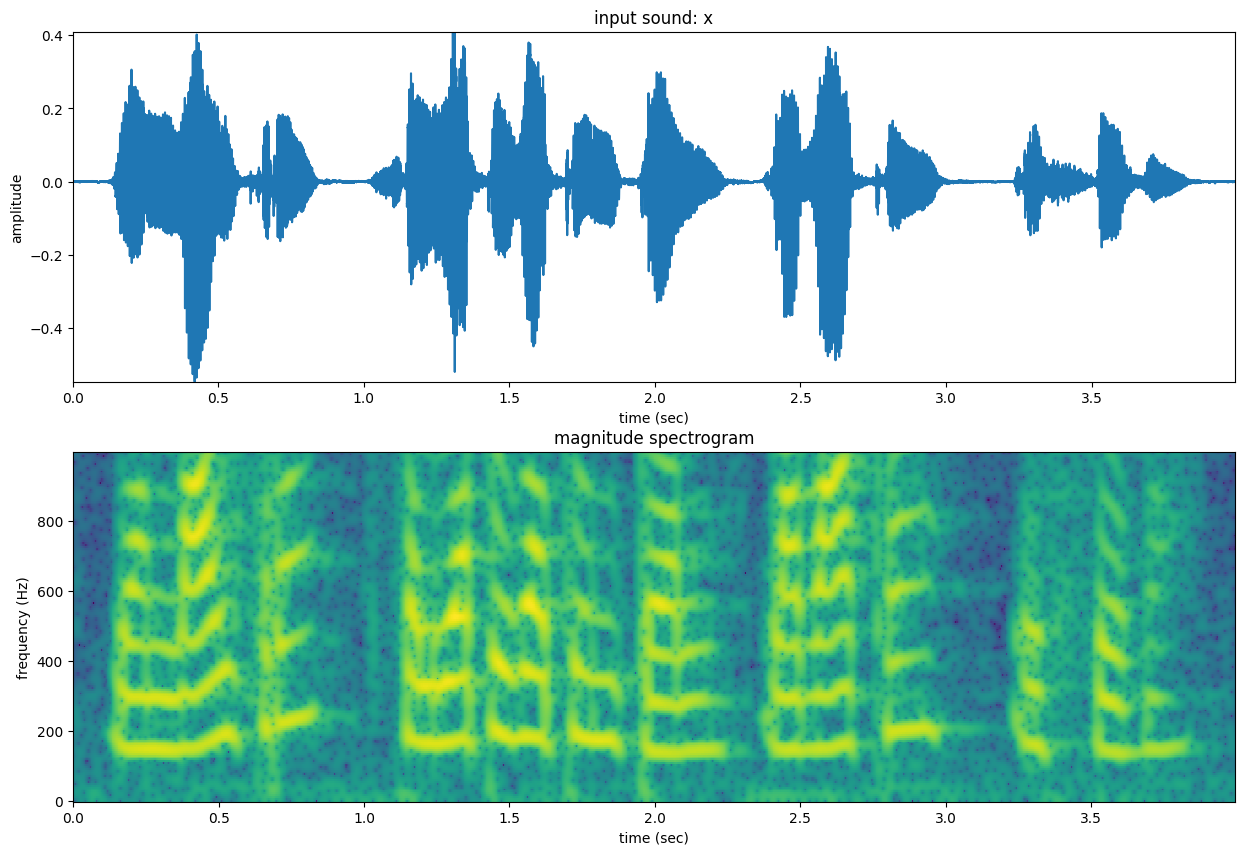

In [ ]:
# E7 - 1.1: 
# Set STFT analysis parameters and visualize spectrogram of speech-female.wav sound

input_file = '../sounds/speech-female.wav'

### set parameters
window = 'blackmanharris'
M = 4096
N = 8192
H = 128
    
# no need to modify anything after this
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 10))
maxplotfreq = 1000.0

# plot input sound
plt.subplot(2,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')

# plot magnitude spectrogram
plt.subplot(2,1,2)
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

The speech-female.wav, is a typical example of spoken human female voice. It exhibits a strong harmonic structure during voiced segments (vowels and some consonants), characterized by a fundamental frequency (f0​) that ranges from 100 Hz to 300 Hz (see in spectrogram). This moderate pitch range requires sufficient frequency resolution (M) to resolve the harmonics, particularly at the lower end. The sound also contains significant stochastic (noise) components during unvoiced sounds (fricatives) and transients at the start and end of words. The complexity of the vowels means the maximum number of perceptually relevant harmonics (nH) needed for accurate representation is high, to capture the specific characteristics of the formants. The HPS analysis must accurately track the fluctuating f0​ during speech and cleanly separate the tonal (harmonic) parts from the noisy (stochastic) parts to achieve high-quality synthesis.

In [67]:
# E7 - 1.2: 
# Perform Harmonic plus Stochastic analysis and synthesis of speech-female.wav sound

input_file = '../sounds/speech-female.wav'

### fill the parameters
window = 'blackmanharris'
M = 2048
N = 4096
t = -120        
minSineDur = 0.1
nH = 50        
minf0 = 100   
maxf0 = 300   
f0et = 10       
harmDevSlope = 0.01
stocf = 0.2   

# no need to modify anything after this
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

**Question E7 - 1.3:**

### Explain the HPS analysis parameters used

The final parameter set for analyzing speech-female.wav was chosen to achieve an optimal trade-off between maximum data compression and the preservation of perceptual quality of the human voice. This approach is paramount in speech coding, where intelligibility and natural timbre must be maintained, even with a reduced data representation. This strategy is reflected in key parameter choices, such as the moderate harmonic limit (nH=50) and the compression of the stochastic residual (stocf=0.2), actively pursuing compacting without introducing noticeable auditory artifacts.

The Blackman-Harris window is selected for its high side-lobe suppression, which minimizes spectral leakage to yield cleaner harmonic peaks. A large window size (M=2048) is used to provide high frequency resolution, ensuring accurate separation and estimation of harmonics, with the FFT size (N=4096) set to twice M for optimal peak estimation.

The f0​ range is constrained between 100 Hz and 300 Hz, covering the female vocal register, and the flexible error threshold (f0et=10) is chosen to reliably maintain f0​ tracking across the rapid pitch variations characteristic of speech. The very low peak threshold (t=−120 dB) is employed to ensure the capture of all subtle harmonic components, preserving the richness of the voice's timbre.

To balance data compression with perceptual quality, the maximum number of harmonics (nH) is limited to 50. This moderate number reduces the sinusoidal data size while still capturing the necessary partials to define the voice's crucial vowel formants. A long minimum sine duration (minSineDur=0.1 s) filters out unstable, transient harmonic tracks, improving harmonic compacting. Finally, the stochastic decimation factor (stocf=0.2) is chosen to create a compact and smoothed spectral envelope of the residual noise, effectively compressing the representation of unvoiced segments (fricatives and sibilants) while maintaining perceptual detail.
____

## Part 2. Obtain a good harmonic+stochastic analysis of a monophonic musical phrase

Analyze and synthesize a harmonic sound of your choice from Freesound using the harmonic plus stochastic model. The goal is to obtain the best possible reconstruction using the most compact representation possible. Return an explanation of what you have done and why, together with the re-synthesized sounds.

The sound from freesound to use could be in any format, but to use the sms-tools software you will have to first convert it to be a monophonic file (one channel), sampling rate of 44100, and 16bits samples. You might also have to select a fragment of the sound.

_Part 2.1:_ Choose a sound from freesound to be analyzed, download it, and if necessary, edit it, and covert it to the right format. It should be a short monophonic musical fragment of a harmonic sound, not longer than 5 seconds. In the explanation add the freesound link of the sound selected and write a brief explanation of why you chose this sound.

_Part 2.2:_ Analyze the chosen sound with the STFT, or with any other analysis or tool you might wish, and describe the characteristics of the sound that will be relevant to perform the harmonic plus stochastic analysis. Important characteristics for the analysis include the pitch range and the maximum number of harmonics. Write no more than a paragraph.

_Part 2.3:_ Select the analysis parameters that give a good reconstruction and at the same time result in to the most compact representation, specially related to the number of harmonic and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. In your descriptions do not use more than one sentence per parameter.

In [41]:
# E7 - 2.1: 
# Download a sound from freesound, read it with waveread, and describe it

#### your code here
input_file = '../sounds/guitarcleanmelody.wav' 
(fs, x) = UF.wavread(input_file)
ipd.display(ipd.Audio(data=x, rate=fs))

**Question E7 - 2.2:**

### write a brief description of the sound

My objective was to analyze a Mongolian diphonic song, but since this sound can be understood as polyphonic, I have chosen to take a simple guitar melody, since it is my main instrument. The url of the sound is: https://freesound.org/s/134790/.

The sound is a short melody played on an electric guitar with a clean tone (without distortion or overdrive).

This sound is primarily harmonic due to the nature of stringed instruments, and its spectrogram will display clear harmonic lines that change frequency as the pitch of the note changes. The fundamental frequency (f0​) range will be relatively low, determined by the notes of the melody, thus requiring a large window size to resolve the closely spaced harmonics. Each note will feature a sharp transient attack (the sound of the pick), which is a key component to be captured by the stochastic (residual) part of the model, followed by a tonal sustain and decay phase. The effective capture of both the low-frequency f0​ range and the transient attacks is critical for accurate HPS analysis and high-quality synthesis.


Text(0.5, 1.0, 'magnitude spectrogram')

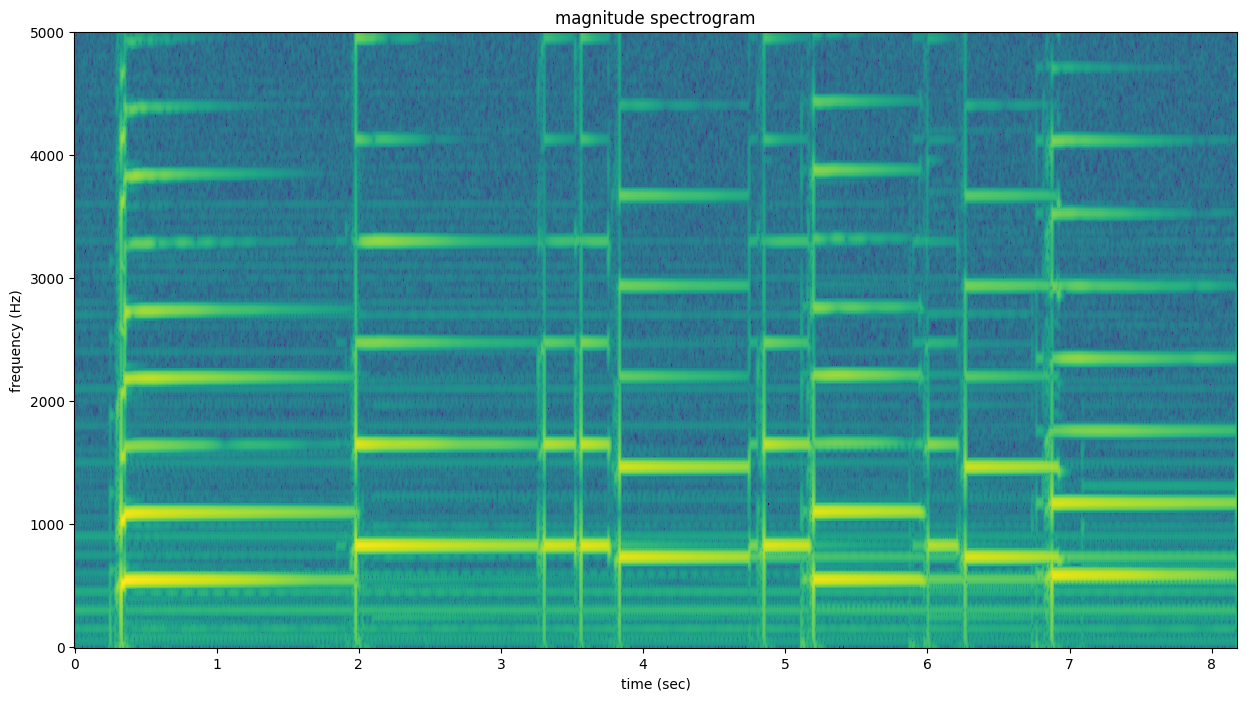

In [47]:
# E7 - 2.3: 
# Set STFT analysis parameters and visualize spectrogram of chosen sound. Explain relevant sound 
# characteristics for HPS model.

### basic visualization and listening of sound
input_file = '../sounds/guitarcleanmelody.wav' 
window = 'blackmanharris'
M = 2048    
N = 4096
H = 128

# no need to modify anything after here
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 8))
maxplotfreq = 5000.0
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

**Question E7 - 2.4:**

### Describe the characteristics relevant to perform the harmonic plus stochastic analysis

The sound of the guitar melody, with notes ranging from C#5​ to G#5​, is characterized by a high and narrow fundamental frequency (f0​) range, spanning approximately 550 Hz to 830 Hz. This high f0​ means the harmonics are widely spaced, which allows for the use of a smaller window size (M), to prioritize temporal resolution for better note tracking and capture of transients without compromising frequency resolution. The number of perceptually relevant harmonics (nH) will be low, since the high f0​ severely limits how many partials fit within the audible spectrum. Crucially, the stochastic component of the model must effectively capture the pick attack noise and other transients associated with the onset of each note, as these elements are vital for the articulation and percussive quality of the melody.
____


In [49]:
# E7 - 2.5: 
# Perform Harmonic plus Stochastic analysis and synthesis of chosen sound.


### fill the parameters
### explicaciones en castellano para aclararme con los parametros
window = 'blackmanharris'     # Ventana con alta supresión de lóbulos laterales para mejor definición espectral, esencial para un timbre limpio.
M = 2048                      # Tamaño de ventana largo para alta resolución de frecuencia, esencial para capturar los armónicos estables.
N = 4096                      # FFT size (2*M) para una estimación precisa de picos espectrales mediante interpolación.
t = -120                      # Umbral muy bajo para conservar las armónicas débiles.
minSineDur = 0.1              # Duración mínima larga para asegurar que solo se capturan las notas estables, eliminando armónicas de ataques y transitorios rápidos.
nH = 50                       # Limita el número máximo de armónicos a 50, asegurando una representación compacta, ya que la f0 alta (<500 Hz) reduce la cantidad de armónicos relevantes.
minf0 = 500                   # Límite inferior para f0 por encima de la nota más baja (C#5 ≈ 554 Hz), eliminando ruido de baja frecuencia.
maxf0 = 900                   # Límite superior para f0 que cubre la nota más alta (G#5 ≈ 831 Hz) con margen de seguridad.
f0et = 5                      # Umbral de error estricto en la detección de f0 para evitar saltos o errores tonales, manteniendo la precisión.
harmDevSlope = 0.01           # Pendiente positiva que permite una desviación armónica ligeramente mayor en las frecuencias altas, manteniendo el realismo.
stocf = 0.2                   # Factor de diezmado bajo para obtener una envolvente residual compacta y detallada, crucial para capturar el ataque de púa.

# No need to modify
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

**Question E7 - 2.5**

### Explain the choices of HPS analysis parameters

The selection of these HPS parameters is optimized for analyzing a high-pitched, clean guitar melody with the dual goals of high reconstruction fidelity and data compacting. The Blackman-Harris window is chosen for its superior spectral definition, which helps isolate the harmonics clearly. A long window size (M=2048) and corresponding FFT size (N=4096) are necessary to provide the high frequency resolution needed to accurately capture the subtle, stable harmonic structure that defines the guitar's clean timbre. Due to the high f0​ range (500 Hz to 900 Hz), the minf0 and maxf0 bounds are set high to restrict the search space, drastically improving the accuracy of the f0​ detection algorithm, which is further refined by a strict f0et of 5. The very low threshold (t=−120 dB) is crucial for preserving the quiet, high-frequency harmonics that contribute to the brightness. For compacting the sinusoidal data, a long minimum sine duration (minSineDur=0.1 s) filters out any brief, noisy harmonic tracks, ensuring only stable pitches are stored, while the maximum number of harmonics (nH=50) is capped to reflect the limited number of partials available due to the high f0​. Finally, the stochastic decimation factor (stocf=0.2) is chosen to create a smooth, compact envelope that effectively models the non-pitched noise of the finger and pick attacks, which are perceptually vital for the rhythm and articulation.

Perceptually, the reconstruction is nearly identical to the original sound, and based on the analysis, the peak picking threshold (t=−120 dB) proves to be the most decisive parameter (apart from the f0​ limits). This is because setting t this low ensures that the maximum number of subtle, high-frequency partials of the clean guitar are retained in the harmonic component, directly preserving the brightness and richness of the timbre that would otherwise be lost to the residual component if the threshold were higher.
___